In [18]:
#1加载必要的库
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim.optimizer import Optimizer
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets,transforms

In [108]:
#定义晶体管参数
Pmax=501
Gmax=1
Gmin=0
o0=0.01 #c2c 引入器件误差
def G(x):
  return (1-np.exp(-x/100))/0.9933
def G_1(x):
  return -np.log(1-x*0.9933)*100
def wnew(w,dw):    
  #Wq=torch.round(w*Pmax)/Pmax
  Gq=(w-1)/2*(Gmax-Gmin)+Gmax
  P=torch.round(G_1(Gq))
  dp=torch.round(dw/2*Pmax)
  Gnew=G(P+dp)
  y=(Gnew-Gmin)/(Gmax-Gmin)*2-1
  return y
def wwnew(w,dw):
  Gq=(w-1)/2*(Gmax-Gmin)+Gmax
  P=(G_1(Gq))
  dp=(dw/2*Pmax)
  Gnew=G(P+dp)
  y=(Gnew-Gmin)/(Gmax-Gmin)*2-1
 
  
  return y

#晶体管权重更新函数
a=torch.tensor([0,0.08])
b=torch.tensor([0,0.0001])

print(wwnew(a,b))

tensor([-5.9605e-08,  8.0234e-02])


In [109]:
#2定义超参数
BATCH_SIZE =128 # 每批处理的数据
DEVICE = torch.device("cuda"if torch.cuda.is_available() else "cpu")#
EPOCHS = 20 #训练数据集的轮次


In [110]:
#3构建pipeline，对图像做处理
pipeline = transforms.Compose([
    transforms.ToTensor(),#将图片转换成tensor
    transforms.Normalize((0.1307,),(0.3081,))#正则化：降低模型复杂度
 ])

In [111]:
#4下载，加载数据
from torch.utils.data import DataLoader
#下载数据集
train_set = datasets.MNIST("data",train=True,download=True,transform=pipeline)

test_set = datasets.MNIST("data",train=False,download=True,transform=pipeline)
#加载数据集
train_loader =DataLoader(train_set,batch_size=BATCH_SIZE,shuffle=True)

test_loader= DataLoader(test_set,batch_size=BATCH_SIZE,shuffle=True)


In [112]:
# 插入代码，显示MNIST中图片
with open("./data/MNIST/raw/train-images-idx3-ubyte","rb") as f:
    file=f.read()

In [113]:
image1 = [int(str(item).encode("ascii"),16) for item in file[16:16+784]]
print(image1)
image2 = [int(str(item).encode("ascii"),16) for item in file[16+784:16+784*2]]
print(image2)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 24, 24, 24, 294, 310, 373, 38, 358, 597, 583, 295, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 48, 54, 148, 340, 368, 595, 595, 595, 595, 595, 549, 370, 595, 578, 405, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 73, 568, 595, 595, 595, 595, 595, 595, 595, 595, 593, 147, 130, 130, 86, 57, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 24, 537, 595, 595, 595, 595, 595, 408, 386, 583, 577, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 128, 342, 263, 595, 595, 517, 17, 0, 67, 340, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 20, 1, 340, 595, 1

In [114]:
import cv2
import numpy as np

image1_np =np.array(image1,dtype=np.uint8).reshape(28,28,1)
print(image1_np.shape)
cv2.imwrite("digit1.jpg",image1_np)
image2_np =np.array(image2,dtype=np.uint8).reshape(28,28,1)
print(image2_np.shape)
cv2.imwrite("digit2.jpg",image2_np)

(28, 28, 1)
(28, 28, 1)


True

In [115]:

# 5 构建网络模型
class Digit(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, 5) #第一个卷积层（1：输入的灰度图的通道，10：输出通道，5：卷积层Kernel）
        self.conv2 = nn.Conv2d(10, 20, 3) #第二个卷积层（10：输入通道，20：输出通道，3：卷积层Kernel）
        self.fc1 = nn.Linear(20*10*10, 500) #第一个全连接层（20*10*10：输入通道，500：输出通道）
        self.fc2 = nn.Linear(500, 10) #第二个全连接层（500：输入通道，10：输出通道【0~9】）
        
    def forward(self, x):
        input_size = x.size(0) # batch_size
        x = self.conv1(x) # 输入：batch*1*28*28，输出：batch*10*24*24 (28-5+1=24)
        x = F.relu(x) #激活函数，保持shape不变，输出：batch*10*24*24
        x = F.max_pool2d(x, 2, 2) #池化层 输入：batch*10*24*24， 输出：batch*10*12*12
        
        x = self.conv2(x) # 输入：batch*10*12*12，输出：batch*20*10*10 （12-3+1=10）
        x = F.relu(x) # 
        
        x = x.view(input_size, -1) # 拉平， -1：自动计算维度  20*10*10=2000
        
        x = self.fc1(x) # 输入：batch*2000 输出：batch*500
        x = F.relu(x) # 激活， 保持shape不变
        
        x = self.fc2(x) # 输入：batch*500，输出：batch*10
        
        output = F.log_softmax(x, dim=1) #计算分类后，每个数字0~9的概率
        
        return output


In [116]:
#自定义优化器

class MyOptimizer(Optimizer):
    def __init__(self, params, lr):
        self.lr = lr
        super(MyOptimizer, self).__init__(params, {})

    def step(self, closure=False):	
        
        for param_group in self.param_groups:
            params = param_group['params']
            # 从param_group中拿出参数
            for param in params:
                # 循环更新每一个参数的值
                #param.data = param.data - self.lr * param.grad #纯软件
                param.data = wwnew(param.data,- self.lr*param.grad) #晶体管模拟



In [117]:
#6定义优化器
model = Digit().to(DEVICE)
#optimizer = optim.SGD(model.parameters(),0.1)
optimizer = MyOptimizer(model.parameters(),0.01)


In [118]:
#7定义训练方法
def train_model(model, device, train_loader, optimizer, epoch):
    # 模型训练
    model.train()
    for batch_index, (img, target) in enumerate(train_loader):
        # 将数据部署到DEVICE上去
        img, target = img.to(device), target.to(device)
        # 梯度初始化为0
        optimizer.zero_grad()
        # 训练后的结果
        output = model(img)
        # 计算loss
        loss = F.cross_entropy(output, target) #cross_entropy适合多分类问题，将计算结果与真实值对比
        # 反向传播
        loss.backward()

        # 参数优化
        optimizer.step() # 用step方法更新参数
      
    
        # 每隔3000张图片打印一次loss
        if batch_index % 3000 == 0:
            print("Train Epoch : {} \t Loss : {:.8f}".format(epoch, loss.item()))


In [119]:
# 8 定义测试方法

def test_model(model, device, test_loader):
    # 模型验证
    model.eval()
    # 初始化正确率
    correct = 0.0
    # 初始化测试loss
    test_loss = 0.0
    with torch.no_grad(): # 测试时不会计算梯度，也不会进行反向传播
        for img, target in test_loader:
            # 部署到DEVICE上
            img, target = img.to(device), target.to(device)
            # 测试数据
            output = model(img)
            # 计算测试损失
            test_loss += F.cross_entropy(output, target).item()
            # 找到概率最大下标
            pred = output.max(1, keepdim=True)[1] #值，索引 
                # pred = output.argmax(dim=1)
                # pred = torch.max(output, dim=1)
            # 累计正确的值
            correct += pred.eq(target.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        test_accuracy =100 * correct / len(test_loader.dataset)
        print("Test --Average loss : {:.4f}, Accuracy : {:.3f}\n".format(
            test_loss, test_accuracy))
    return(test_accuracy)


Train Epoch : 1 	 Loss : 2.30289531
Test --Average loss : 0.0017, Accuracy : 93.180

93.18
Train Epoch : 2 	 Loss : 0.15405929
Test --Average loss : 0.0007, Accuracy : 97.140

97.14
Train Epoch : 3 	 Loss : 0.12957472


KeyboardInterrupt: 

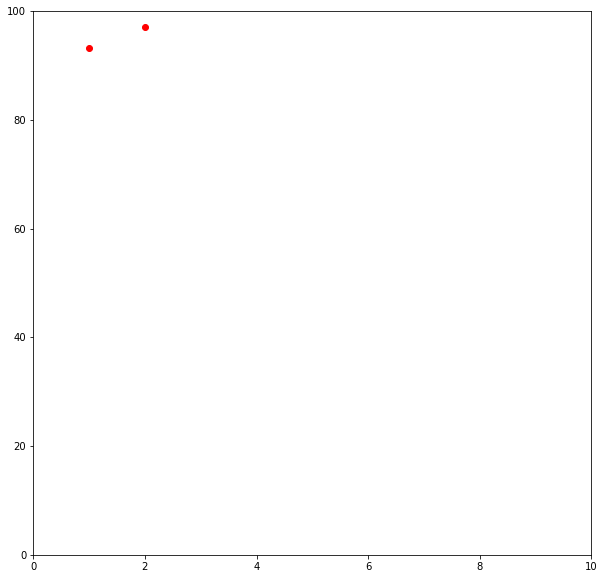

In [120]:
# 9 调用方法7、8
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import style

plt.figure(figsize=(10, 10))  # 设置图像大小
plt.axis([0, 10, 0, 100])
for epoch in range(1, EPOCHS + 1):
    train_model(model, DEVICE, train_loader, optimizer, epoch)
    t_a=test_model(model, DEVICE, test_loader)
    print(t_a)
    plt.scatter(epoch, t_a,color='r', marker='o')
    scale = range(100)


plt.show()

